In [3]:
#!pip install --upgrade pip
!pip install pyathena

  Using cached pyathena-3.3.0-py3-none-any.whl.metadata (86 kB)
  Using cached urllib3-2.0.7-py3-none-any.whl.metadata (6.6 kB)
Using cached pyathena-3.3.0-py3-none-any.whl (80 kB)
Using cached urllib3-2.0.7-py3-none-any.whl (124 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.
sagemaker 2.199.0 requires urllib3<1.27, but you have urllib3 2.0.7 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
#Upgrade de la version de seaborn para poder hacer graficos mas facil 
!pip install seaborn==0.12.2

  Using cached seaborn-0.12.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [5]:
#Libraries
from pyathena import connect
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing


In [6]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'analytics'
tablaSource = 'source_fraud_fechas_label'


In [7]:
#Connection

conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
date_to_compare1 = '2023-01-01'
date_to_compare2 = '2023-05-01'

df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
            where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-02-01'  as date);''', conn)


/tmp/ipykernel_16/517809514.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_source = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label


In [ ]:
#df_source2 = pd.read_sql('''SELECT * FROM analytics.source_fraud_fechas_label 
#             where date_receiver_clean between cast('2023-01-01'  as date) and cast('2023-01-15'  as date);''', conn)


In [8]:
df_source.head()

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,id_payer,id_sender_global,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_to_last_transaction,day,date_receiver2,id_sender2,fraud_type,date_receiver_clean
0,A18386,106651,2023-01-25 19:44:38.970000000,19,Wednesday,140.0,P,0,0,0,...,T232,7808484,46168,4,287,2023-01-25,2023-01-25 19:44:38.970,6229.0,None,2023-01-25
1,A08812,76271,2023-01-25 09:13:36.180000000,09,Wednesday,100.0,P,0,0,0,...,T085,2265946,5467,4,338,2023-01-25,2023-01-25 09:13:36.180,533.0,None,2023-01-25
2,A15234,38786,2023-01-25 08:51:37.177000000,08,Wednesday,240.0,P,0,0,0,...,T061,9582768,2841,771,329,2023-01-25,2023-01-25 08:51:37.177,2776.0,None,2023-01-25
3,A11490,303397,2023-01-25 08:36:50.360000000,08,Wednesday,183.0,C,0,0,0,...,T229,5444963,9880,1,310,2023-01-25,2023-01-25 08:36:50.360,17718.0,None,2023-01-25
4,A05998,94138,2023-01-25 10:34:14.280000000,10,Wednesday,170.0,P,0,0,0,...,T232,3280602,8649,66,301,2023-01-25,2023-01-25 10:34:14.280,10603.0,None,2023-01-25


In [9]:
df_source['mes'] = df_source['date_receiver_clean'].dt.month
df_source['fraud_type'] = df_source['fraud_type'].str.capitalize()

## Creo las nuevas variables
### sender_days_to_last_transaction_365 y sender_days_to_last_transaction_more365
### sender_minutes_since_last_transaction_2days
### net_amount_receiver?

In [10]:
#defino corte en funcion deñ percenti
df_source['sender_days_to_last_transaction'].describe()

count    1.759577e+06
mean     2.588408e+02
std      1.146905e+02
min      0.000000e+00
25%      2.030000e+02
50%      3.210000e+02
75%      3.400000e+02
max      3.640000e+02
Name: sender_days_to_last_transaction, dtype: float64

In [11]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_days_to_last_transaction_365'] = df_source['sender_days_to_last_transaction']
df_source['sender_days_to_last_transaction_more365'] = 0
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0 

/tmp/ipykernel_16/461507757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_days_to_last_transaction_more365[df_source['sender_days_to_last_transaction']> 365] = 1
/tmp/ipykernel_16/461507757.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_days_to_last_transaction_365[df_source['sender_days_to_last_transaction']> 365] = 0


In [12]:
#defino dos nuevas variables a partir de la anterior
df_source['sender_minutes_since_last_transaction_2days'] = df_source['sender_minutes_since_last_transaction']
df_source['sender_minutes_since_last_transaction_1day'] = df_source['sender_minutes_since_last_transaction']
#corto en un maximo de dias y el resto lo pongo enlas variables nuevas
df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0

/tmp/ipykernel_16/2804084275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_minutes_since_last_transaction_2days[df_source['sender_minutes_since_last_transaction']> 2*24*60] = 0
/tmp/ipykernel_16/2804084275.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_source.sender_minutes_since_last_transaction_1day[df_source['sender_minutes_since_last_transaction']> 24*60] = 0


## Estandarizo variables
### sender_days_to_last_transaction_365, sender_minutes_since_last_transaction_2days, net_amount_receiver, sender_sending_days, branch_working_days, receiver_transaction_count

In [13]:
df_source['receiver_transaction_count'].describe()

count    1.759577e+06
mean     1.852189e+01
std      2.377063e+01
min      1.000000e+00
25%      3.000000e+00
50%      1.000000e+01
75%      2.500000e+01
max      6.660000e+02
Name: receiver_transaction_count, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<AxesSubplot:xlabel='01_receiver_transaction_count', ylabel='Count'>

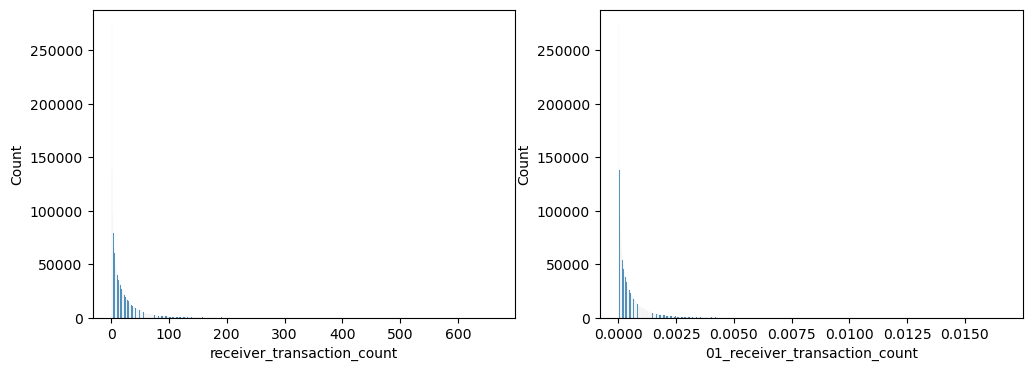

In [14]:
df_source['01_receiver_transaction_count']  = preprocessing.normalize([df_source['receiver_transaction_count']]).T

M = df_source['receiver_transaction_count'] .max()
m = M = df_source['receiver_transaction_count'] .min()

#df_source['01_receiver_transaction_count'] = (df_source['receiver_transaction_count'] -m)/(M-m)

#scaler = preprocessing.MinMaxScaler(feature_range =(0,1))
#d = scaler.fit_transform([df_source['receiver_transaction_count']])
#print(d)
#df_source['01_receiver_transaction_count']  = d.T

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="receiver_transaction_count", ax = axs[0])
sns.histplot(data=df_source, x="01_receiver_transaction_count", ax = axs[1])


In [15]:
df_source['sender_sending_days'].describe()

count    1.759577e+06
mean     2.384400e+02
std      1.376498e+02
min      0.000000e+00
25%      1.100000e+02
50%      2.890000e+02
75%      3.640000e+02
max      3.960000e+02
Name: sender_sending_days, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<AxesSubplot:xlabel='01_sender_sending_days', ylabel='Count'>

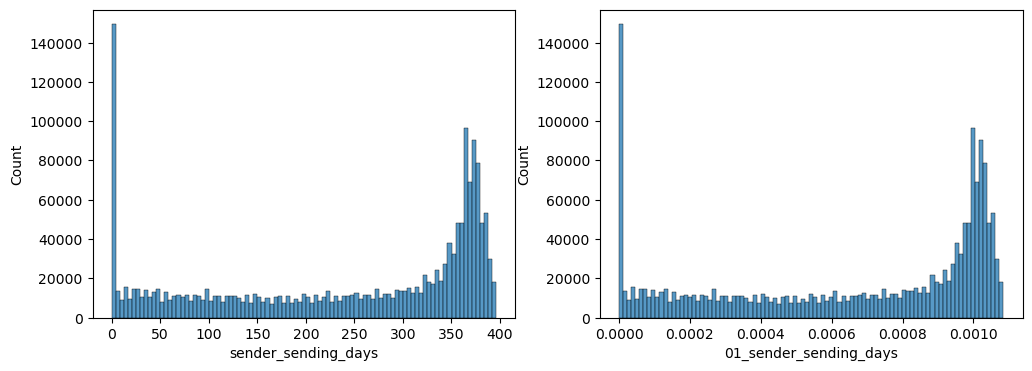

In [16]:
df_source['01_sender_sending_days']  = preprocessing.normalize([df_source['sender_sending_days']]).T

fig, axs = plt.subplots(1,2,figsize = (12, 4))
sns.histplot(data=df_source, x="sender_sending_days", ax = axs[0])
sns.histplot(data=df_source, x="01_sender_sending_days", ax = axs[1])

In [17]:
df_source['branch_working_days'].describe()

count    1.759577e+06
mean     1.602328e+03
std      1.399186e+03
min      0.000000e+00
25%      5.780000e+02
50%      1.117000e+03
75%      2.260000e+03
max      6.567000e+03
Name: branch_working_days, dtype: float64

In [18]:
df_source['net_amount_receiver'].describe()

count    1.759577e+06
mean     4.560110e+02
std      5.789033e+02
min      6.400000e-01
25%      1.000000e+02
50%      2.200000e+02
75%      5.363900e+02
max      7.994000e+03
Name: net_amount_receiver, dtype: float64

In [19]:
df_source['sender_minutes_since_last_transaction_2days'].describe()

count    1.759577e+06
mean     9.519928e+01
std      4.268472e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.880000e+03
Name: sender_minutes_since_last_transaction_2days, dtype: float64

In [20]:
df_source['sender_minutes_since_last_transaction_1day'].describe()

count    1.759577e+06
mean     2.490717e+01
std      1.691219e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.440000e+03
Name: sender_minutes_since_last_transaction_1day, dtype: float64

In [21]:
df_source['sender_days_to_last_transaction_365'].describe()

count    1.759577e+06
mean     2.588408e+02
std      1.146905e+02
min      0.000000e+00
25%      2.030000e+02
50%      3.210000e+02
75%      3.400000e+02
max      3.640000e+02
Name: sender_days_to_last_transaction_365, dtype: float64

In [22]:
df_source['branch_minutes_since_last_transaction'].describe()

count    1.759577e+06
mean     1.205041e+02
std      7.713593e+02
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      3.900000e+01
max      4.291250e+05
Name: branch_minutes_since_last_transaction, dtype: float64

In [23]:
# Normalizo a lo bruto. Dsp reviso el algoritmo
df_source['01_receiver_transaction_count'] = preprocessing.normalize([df_source['sender_sending_days']]).T
df_source['01_sender_sending_days'] = preprocessing.normalize([df_source['sender_sending_days']]).T
df_source['01_branch_working_days'] = preprocessing.normalize([df_source['branch_working_days']]).T
df_source['01_net_amount_receiver'] = preprocessing.normalize([df_source['net_amount_receiver']]).T
df_source['01_sender_minutes_since_last_transaction_2days'] = preprocessing.normalize([df_source['sender_minutes_since_last_transaction']]).T
df_source['01_sender_minutes_since_last_transaction_1day'] = preprocessing.normalize([df_source['sender_minutes_since_last_transaction']]).T
df_source['01_sender_days_to_last_transaction_365'] = preprocessing.normalize([df_source['sender_days_to_last_transaction']]).T

In [24]:

df_source['01_receiver_transaction_count'].describe()
df_source['01_sender_sending_days'].describe()
df_source['01_branch_working_days'].describe()
df_source['01_net_amount_receiver'].describe()
df_source['01_sender_minutes_since_last_transaction_2days'].describe()
df_source['01_sender_minutes_since_last_transaction_1day'].describe()
df_source['01_sender_days_to_last_transaction_365'].describe()

count    1.759577e+06
mean     6.892395e-04
std      3.053971e-04
min      0.000000e+00
25%      5.405470e-04
50%      8.547566e-04
75%      9.053497e-04
max      9.692567e-04
Name: 01_sender_days_to_last_transaction_365, dtype: float64

## Creacion del target

In [25]:
df_source['fraud_type'].value_counts()

fraud_type
Remote access    55
Payment          35
Money order       2
Red phone         1
Name: count, dtype: int64

In [26]:
# defino los targets
df_source['target1'] = df_source['fraud_type'] == 'Remote access'
df_source['target2'] = df_source['fraud_type'] == 'Payment'
df_source['target_fraudes'] = df_source['fraud_type'].notnull()


In [27]:
df_source['target1'].value_counts()

target1
False    1759522
True          55
Name: count, dtype: int64

In [28]:
df_source['target2'].value_counts()

target2
False    1759542
True          35
Name: count, dtype: int64

In [29]:
df_source['target_fraudes'].value_counts()

target_fraudes
False    1759484
True          93
Name: count, dtype: int64

## Guardo archivos para dsp juntar en el entrenamiento

In [30]:
#Me quedo con las variables q voy a usar
df_source.columns.values
df = df_source [['id_branch', 'id_receiver', 'hour_receiver','day_name_receiver','net_amount_receiver','was_ofac_receiver_hit','was_ofac_sender_hit',
          'receiver_transaction_count','branch_working_days','sender_sending_days','branch_minutes_since_last_transaction','sender_days_to_last_transaction',
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365',
           'fraud_type','date_receiver_clean','target1','target2','target_fraudes']
          ]
##'sender_days_since_last_transaction','sender_minutes_since_last_transaction'

In [31]:
import os
import pyarrow as pa
import pyarrow.parquet as pq

In [32]:
#guardar_dataset_con_valor_parquet(df_source, columna_nombre='mes', nombre_archivo='Prepoc_Fraude',carpeta='ABT') # save ABT in parquet format

## Entreno para probar

In [33]:
#s3_url = 's3://viamericas-datalake-dev-us-east-1-283731589572-raw/exp1.parquet'
df_source.to_parquet(path='./exp1.parquet', engine='pyarrow', compression='gzip')
print('termine de salvar el parquet')

termine de salvar el parquet


In [35]:
s3_url = 's3://viamericas-datalake-dev-us-east-1-283731589572-raw/exp1.parquet'
df = pd.read_parquet(s3_url)

In [36]:
df.head(5)

,id_branch,id_receiver,date_receiver,hour_receiver,day_name_receiver,net_amount_receiver,id_payout,was_fraud,was_fraud_pattern,was_ofac_receiver_hit,...,01_receiver_transaction_count,01_sender_sending_days,01_branch_working_days,01_net_amount_receiver,01_sender_minutes_since_last_transaction_2days,01_sender_minutes_since_last_transaction_1day,01_sender_days_to_last_transaction_365,target1,target2,target_fraudes
0,A19925,88743,2023-01-15 13:30:04.213000000,13,Sunday,650.0,C,0,0,0,...,0.000077,0.000077,0.000303,0.000665,1.985847e-04,1.985847e-04,0.000168,False,False,False
1,A22569,1380,2023-01-15 13:37:14.937000000,13,Sunday,299.0,P,0,0,0,...,0.000000,0.000000,0.000091,0.000306,5.299550e-08,5.299550e-08,0.000596,False,False,False
2,A11108,85216,2023-01-15 13:52:07.197000000,13,Sunday,1010.0,P,0,0,0,...,0.000860,0.000860,0.001105,0.001033,2.699591e-05,2.699591e-05,0.000748,False,False,False
3,A18861,73770,2023-01-15 13:43:33.410000000,13,Sunday,65.0,C,0,0,0,...,0.001016,0.001016,0.000384,0.000066,9.150202e-05,9.150202e-05,0.000860,False,False,False
4,A15339,91550,2023-01-15 13:45:30.277000000,13,Sunday,50.0,P,0,0,0,...,0.000501,0.000501,0.000748,0.000051,4.570862e-04,4.570862e-04,0.000125,False,False,False


In [42]:
features.shape

(1759577, 9)

In [46]:
features = df_source [['net_amount_receiver',
           '01_receiver_transaction_count','01_sender_sending_days','01_branch_working_days','01_net_amount_receiver','01_sender_minutes_since_last_transaction_2days',
           '01_sender_minutes_since_last_transaction_1day','01_sender_days_to_last_transaction_365']]
label = df['target_fraudes']
size = 1759577

# Hold out 20% of the dataset for training

test_size = int(np.round(size * 0.2, 0))# Split dataset into training and testing sets
x_train = features[:-test_size].values
y_train = label[:-test_size].values

In [ ]:
from sklearn import svm

model = svm.SVC(kernel='poly', degree=2)
model.fit(x_train, y_train)

In [ ]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "lightgbm-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type
)

# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)

train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

# Sample training data is available in this bucket
training_data_bucket = f"s3://viamericas-datalake-dev-us-east-1-283731589572-raw"
training_data_prefix = "training-datasets/tabular_multiclass/"

training_dataset_s3_path = f"s3://{training_data_bucket}/exp1.parquet" 
validation_dataset_s3_path = f"s3://{training_data_bucket}/exp1.parquet" 

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-tabular-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

from sagemaker import hyperparameters

# Retrieve the default hyperparameters for training the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters[
    "num_boost_round"
] = "500"
print(hyperparameters)

from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"built-in-algo-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1, # for distributed training, specify an instance_count greater than 1
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location
)

# Launch a SageMaker Training job by passing the S3 path of the training data
tabular_estimator.fit(
    {
        "train": training_dataset_s3_path,
        "validation": validation_dataset_s3_path,
    }, logs=True, job_name=training_job_name
)